# Proyecto final: Breast Cancer Wisconsin (Original)

---
### Autores: Grupo 7
Raúl Murillo Montero - 5º Doble Grado en Ingeniería Informática - Matemáticas   
Miguel Sierra Esteso - 4º Grado en Ingeniería Informática


In [1]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.model_selection as ms
import scipy.optimize as opt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import time

## Phase 1 - Data Exploration

In [2]:
# importing our cancer dataset
dataset = pd.read_csv("breast-cancer-wisconsin.csv")
print(dataset.shape)
display(dataset.head())

(699, 11)


,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


### Missing or Null Data points

In [3]:
print(dataset.isin(["?"]).sum())

id                    0
clump_thickness       0
size_uniformity       0
shape_uniformity      0
marginal_adhesion     0
epithelial_size       0
bare_nuclei          16
bland_chromatin       0
normal_nucleoli       0
mitoses               0
class                 0
dtype: int64


In [4]:
# Removing examples with missing data

missing = np.where(dataset["bare_nuclei"] == "?")[0]
dataset.drop(index=missing, inplace=True)
# Set numeric values to the feature
dataset["bare_nuclei"] = pd.to_numeric(dataset["bare_nuclei"])
print(dataset.shape)

(683, 11)


### Data visualization

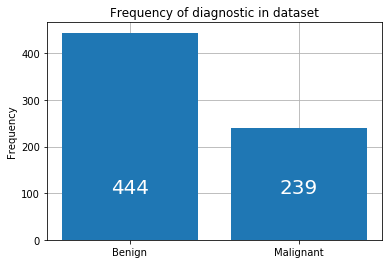

In [5]:
# Plot classes
labelencoder_Y = LabelEncoder()
dataset["class"] = labelencoder_Y.fit_transform(dataset["class"])
Y = dataset["class"].values
plt.figure()
count = [sum(Y == 0), sum(Y == 1)]
plt.grid(zorder=0)
plt.bar(["Benign", "Malignant"], count, zorder=3)
plt.title("Frequency of diagnostic in dataset")
plt.ylabel("Frequency")
plt.text(x=0, y=100, s=count[0], ha="center", color="w", fontsize=20)
plt.text(x=1, y=100, s=count[1], ha="center", color="w", fontsize=20)
plt.savefig("classes.png")
plt.show()

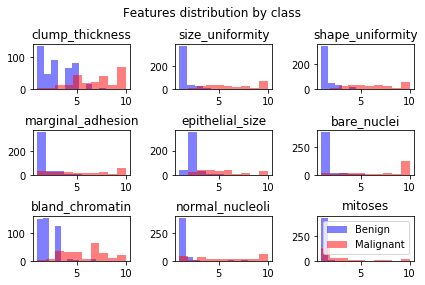

In [6]:
# For different diagnosis visual comparisons
# create two dataframes
neg_dataf = dataset[Y == 0]
pos_dataf = dataset[Y == 1]

features = list(dataset.columns[1:-1])

# Visualize all the features for positive and negative diagnoses
fig = plt.figure()
plt.suptitle("Features distribution by class")

for i, f in enumerate(features):
    i += 1
    ax = fig.add_subplot(3, 3, i)

    # Plot corresponding histogram
    ax.hist(neg_dataf[f], label="Benign", stacked=True, alpha=0.5, color="b")
    ax.hist(
        pos_dataf[f], label="Malignant", stacked=True, alpha=0.5, color="r")
    ax.set_title(f)

plt.tight_layout()
plt.legend()
plt.subplots_adjust(top=0.85)
plt.savefig("features.png")
plt.show()

## Phase 2 - Data preprocessing


In [7]:
X_neg = neg_dataf[features].values
X_pos = pos_dataf[features].values
Y_neg = neg_dataf['class'].values
Y_pos = pos_dataf['class'].values

### Split data into training, validate and test sets

In [8]:
# Split data into train, validation and test sets - 60% 20% 20%

# Class 'Benign'
X_train_neg, X_test_neg, y_train_neg, y_test_neg = ms.train_test_split(
    X_neg, Y_neg, test_size=0.2, random_state=1)
X_train_neg, X_val_neg, y_train_neg, y_val_neg = ms.train_test_split(
    X_train_neg, y_train_neg, test_size=0.25, random_state=1)
# Class 'Malignant'
X_train_pos, X_test_pos, y_train_pos, y_test_pos = ms.train_test_split(
    X_pos, Y_pos, test_size=0.2, random_state=1)
X_train_pos, X_val_pos, y_train_pos, y_val_pos = ms.train_test_split(
    X_train_pos, y_train_pos, test_size=0.25, random_state=1)

# Merge data sets
X_train = np.r_[X_train_neg, X_train_pos]
X_val = np.r_[X_val_neg, X_val_pos]
X_test = np.r_[X_test_neg, X_test_pos]
y_train = np.r_[y_train_neg, y_train_pos]
y_val = np.r_[y_val_neg, y_val_pos]
y_test = np.r_[y_test_neg, y_test_pos]

print(len(X_train), len(X_val), len(X_test))

409 137 137


### Normalize data

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Phase 3 - Model Selection

In [10]:
sigmoid = lambda x: 1 / (1 + np.e**(-x))

### Linear regression

#### As Task 1

In [11]:
J = lambda theta, x, y: 1 / (2 * len(y)) * (
    x.dot(theta) - y).T.dot(x.dot(theta) - y)


def update(theta, x, y, alpha):
    for j in range(len(theta)):
        theta[j] = theta[j] - alpha * np.mean((x.T.dot(theta) - y) * x[j, :])

In [12]:
X_train_ = np.c_[np.ones((len(X_train), 1)), X_train]
X_test_ = np.c_[np.ones((len(X_test), 1)), X_test]
theta = np.zeros(len(features) + 1)
alpha = 0.01

tic = time.process_time()
for n in range(1500):
    update(theta, X_train_.T, y_train, alpha)
toc = time.process_time()
print('Consumed training time: {}'.format(toc - tic))

# Get a prediction
y_pred = X_test_.dot(theta)
y_pred = (y_pred >= 0.5) * 1

# Compute metrics
linreg_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(linreg_matrix)

Consumed training time: 0.328125
Confusion matrix:
[[88  1]
 [ 7 41]]


#### Scikit-learn version

In [13]:
tic = time.process_time()
reg = LinearRegression().fit(X_train, y_train)
toc = time.process_time()
print('Consumed training time: {}'.format(toc - tic))

# Get a prediction
y_pred = reg.predict(X_test)
y_pred = (y_pred >= 0.5) * 1

# Compute metrics
linreg_matrix_sk = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(linreg_matrix_sk)

Consumed training time: 0.0
Confusion matrix:
[[88  1]
 [ 7 41]]


### Logistic regression

#### As Task 2

In [14]:
J = lambda theta, x, y: -((np.log(sigmoid(x.dot(theta)))).T.dot(y) +
                        (np.log(1 - sigmoid(x.dot(theta)))).T.dot(1 - y)) \
                        / len(y)

dJ = lambda theta, x, y: (x.T.dot(sigmoid(x.dot(theta)) - y)) / len(y)

Jreg = lambda theta, x, y, l: J(theta, x, y) + l / (2 * len(y)) * \
                                (np.square(theta[1:]).sum())

dJreg = lambda theta, x, y, l: dJ(theta, x, y) + l * \
                                (np.hstack(([0], theta[1:])) / len(y))

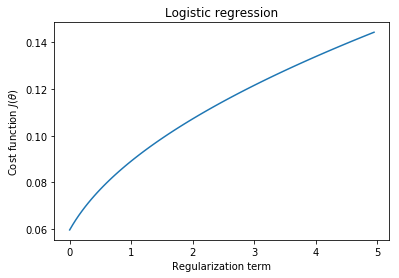

Best regularization term is 0.0
Consumed training time: 0.03125
Confusion matrix:
[[87  2]
 [ 4 44]]


In [15]:
# Hyperparameter tuning
X_train_ = np.c_[np.ones((len(X_train), 1)), X_train]
X_val_ = np.c_[np.ones((len(X_val), 1)), X_val]
theta = np.zeros(len(features) + 1)
costs = []
reg = np.arange(0, 5, 0.05)

for l in reg:
    result = opt.fmin_tnc(
        func=Jreg, x0=theta, fprime=dJreg, args=(X_train_, y_train, l))
    theta_opt = result[0]
    costs.append(Jreg(theta_opt, X_val_, y_val, l))

# Show costs
plt.figure()
plt.plot(reg, costs)
plt.xlabel('Regularization term')
plt.ylabel('Cost function $J(\\theta )$')
plt.title('Logistic regression')
plt.savefig('Logistic_regression.png')
plt.show()

# Model selection
# Pick the model with minimum cross validation error
best_reg = reg[np.argmin(costs)]
print('Best regularization term is {}'.format(best_reg))

tic = time.process_time()
best_theta = opt.fmin_tnc(
    func=Jreg, x0=theta, fprime=dJreg, args=(X_train_, y_train, best_reg))[0]
toc = time.process_time()
print('Consumed training time: {}'.format(toc - tic))

# Get a prediction
y_pred = sigmoid(np.c_[np.ones((len(X_test), 1)), X_test].dot(best_theta))
y_pred = (y_pred >= 0.5) * 1

# Compute metrics
lr_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(lr_matrix)

#### Scikit-learn version

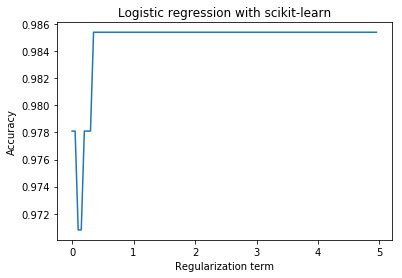

Best regularization term is 0.35000000000000003
Consumed training time: 0.0
Confusion matrix:
[[88  1]
 [ 4 44]]


In [16]:
# Hyperparameter tuning
costs = []
for l in (reg + 0.0000000000001):  # C must be positive
    clf = LogisticRegression(random_state=1, solver='lbfgs', C=l)
    clf.fit(X_train, y_train)
    costs.append(clf.score(X_val, y_val))

# Show scores
plt.figure()
plt.plot(reg, costs)
plt.xlabel('Regularization term')
plt.ylabel('Accuracy')
plt.title('Logistic regression with scikit-learn')
plt.savefig('Logistic_regression-sklearn.png')
plt.show()

# Model selection
# Pick the model with maximum cross validation accuracy
best_reg = reg[np.argmax(costs)]
print('Best regularization term is {}'.format(best_reg))

tic = time.process_time()
clf = LogisticRegression(random_state=1, solver='lbfgs', C=best_reg)
clf.fit(X_train, y_train)
toc = time.process_time()
print('Consumed training time: {}'.format(toc - tic))

# Get a prediction
y_pred = clf.predict(X_test)

# Compute metrics
lr_matrix_sk = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(lr_matrix_sk)

### Neural networks

#### As Task 4

In [17]:
def pesosAleatorios(L_in, L_out):
    eps = 0.12  # it can be assigned by a formula
    # dimension of the matrix is (L_out, 1 + L_in)
    np.random.seed(1)
    return np.random.uniform(low=-eps, high=eps, size=(L_out, 1 + L_in))


def J(theta1, theta2, X, y):
    m = X.shape[0]
    h = forwardprop(theta1, theta2, X)[4]
    return -1 * (1 / m) * np.sum(
        (np.log(h.T) * (y) + np.log(1 - h).T * (1 - y)))


def J_reg(theta1, theta2, X, y, reg):
    m = X.shape[0]
    return J(theta1, theta2, X, y) + (reg) * (np.sum(np.square(
        theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:]))) / (2 * m)


def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))


def forwardprop(theta1, theta2, X):
    m = X.shape[0]
    # Input layer
    a1 = np.c_[np.ones((m, 1)), X]
    # Hidden layer
    z2 = theta1.dot(a1.T)
    a2 = np.c_[np.ones((m, 1)), sigmoid(z2.T)]
    # Output layer
    z3 = theta2.dot(a2.T)
    a3 = sigmoid(z3)
    return (a1, z2, a2, z3, a3)


def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg=0):
    """
    backprop devuelve el coste y el gradiente de una red neuronal de dos capas.
    """
    theta1 = params_rn[:(num_ocultas * (num_entradas + 1))].reshape(
        num_ocultas, (num_entradas + 1))
    theta2 = params_rn[(num_ocultas * (num_entradas + 1)):].reshape(
        num_etiquetas, (num_ocultas + 1))

    m = X.shape[0]
    y_matrix = pd.get_dummies(np.array(y).ravel()).values

    # Cost
    a1, z2, a2, z3, a3 = forwardprop(theta1, theta2, X)

    J = J_reg(theta1, theta2, X, y_matrix, reg)

    # Gradients
    d3 = a3.T - y_matrix
    d2 = theta2[:, 1:].T.dot(d3.T) * d_sigmoid(z2)

    delta1 = d2.dot(a1)
    delta2 = d3.T.dot(a2)

    theta1_ = np.c_[np.zeros((theta1.shape[0], 1)), theta1[:, 1:]]
    theta2_ = np.c_[np.zeros((theta2.shape[0], 1)), theta2[:, 1:]]

    theta1_grad = delta1 / m + (theta1_ * reg) / m
    theta2_grad = delta2 / m + (theta2_ * reg) / m

    return (J, np.r_[theta1_grad.ravel(), theta2_grad.ravel()])

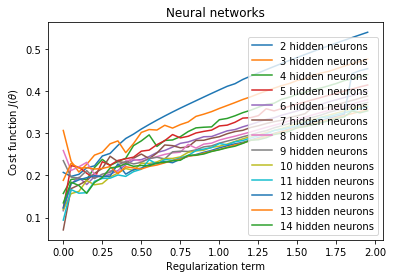

Best regularization term is 0.0
Best number of hidden neurons is 7
Consumed training time: 0.1875
Confusion matrix:
[[87  2]
 [ 2 46]]


In [18]:
num_in, num_out = X_train.shape[1], 2

# Hyperparameter tuning
hidden = range(2, 15)
reg = np.arange(0, 2, 0.05)
costs = np.empty((len(hidden), len(reg)))

for i, h in enumerate(hidden):
    for j, l in enumerate(reg):
        t1 = pesosAleatorios(num_in, h)
        t2 = pesosAleatorios(h, num_out)
        params = np.r_[t1.ravel(), t2.ravel()]

        fmin = opt.minimize(
            fun=backprop,
            x0=params,
            args=(num_in, h, num_out, X_train, y_train, l),
            method='TNC',
            jac=True,
            options={'maxiter': 70})
        # Network Trained!
        Theta1 = fmin.x[:(h * (num_in + 1))].reshape(h, (num_in + 1))
        Theta2 = fmin.x[(h * (num_in + 1)):].reshape(num_out, (h + 1))
        costs[i, j] = J_reg(Theta1, Theta2, X_val,
                            pd.get_dummies(y_val.ravel()).values, l)

# Show costs
plt.figure()
for i, h in enumerate(hidden):
    plt.plot(reg, costs[i], label=str(h) + ' hidden neurons')
plt.xlabel('Regularization term')
plt.ylabel('Cost function $J(\\theta)$')
plt.legend()
plt.title('Neural networks')
plt.savefig('NN.png')
plt.show()

# Model selection
# Pick the model with minimum cross validation error
n = len(reg)
best_hidden = hidden[costs.argmin() // n]
best_reg = reg[costs.argmin() % n]
print('Best regularization term is {}'.format(best_reg))
print('Best number of hidden neurons is {}'.format(best_hidden))

t1 = pesosAleatorios(num_in, best_hidden)
t2 = pesosAleatorios(best_hidden, num_out)
params = np.r_[t1.ravel(), t2.ravel()]
tic = time.process_time()
fmin = opt.minimize(
    fun=backprop,
    x0=params,
    args=(num_in, best_hidden, num_out, X_train, y_train, best_reg),
    method='TNC',
    jac=True,
    options={'maxiter': 70})
toc = time.process_time()
print('Consumed training time: {}'.format(toc - tic))

# Get a prediction
Theta1 = fmin.x[:(best_hidden * (num_in + 1))].reshape(best_hidden,
                                                       (num_in + 1))
Theta2 = fmin.x[(best_hidden * (num_in + 1)):].reshape(num_out,
                                                       (best_hidden + 1))
y_pred = forwardprop(Theta1, Theta2, X_test)[4]
y_pred = np.array(np.argmax(y_pred, axis=0))

# Compute metrics
nn_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(nn_matrix)

#### Scikit-learn version

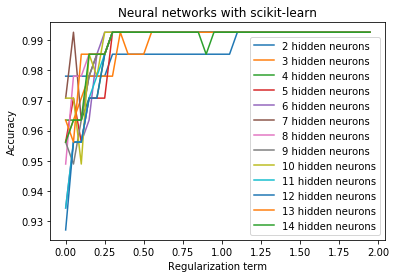

Best regularization term is 1.1
Best number of hidden neurons is 2
Consumed training time: 0.03125
Confusion matrix:
[[87  2]
 [ 4 44]]


In [19]:
# Hyperparameter tuning
costs = np.empty((len(hidden), len(reg)))
for i, h in enumerate(hidden):
    for j, l in enumerate(reg):
        clf = MLPClassifier(
            solver='lbfgs',
            activation='logistic',
            alpha=l,
            hidden_layer_sizes=(h),
            random_state=1)
        clf.fit(X_train, y_train)
        costs[i, j] = clf.score(X_val, y_val)

# Show scores
plt.figure()
for i, h in enumerate(hidden):
    plt.plot(reg, costs[i], label=str(h) + ' hidden neurons')
plt.xlabel('Regularization term')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural networks with scikit-learn')
plt.savefig('NN-sklearn.png')
plt.show()

# Model selection
# Pick the model with maximum cross validation accuracy
n = len(reg)
best_hidden = hidden[costs.argmax() // n]
best_reg = reg[costs.argmax() % n]
print('Best regularization term is {}'.format(best_reg))
print('Best number of hidden neurons is {}'.format(best_hidden))

tic = time.process_time()
clf = MLPClassifier(
    solver='lbfgs',
    activation='logistic',
    alpha=best_reg,
    hidden_layer_sizes=(best_hidden),
    random_state=1)
clf.fit(X_train, y_train)
toc = time.process_time()
print('Consumed training time: {}'.format(toc - tic))

# Get a prediction
y_pred = clf.predict(X_test)

# Compute metrics
nn_matrix_sk = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(nn_matrix_sk)

### Support vector machines

#### Linear kernel

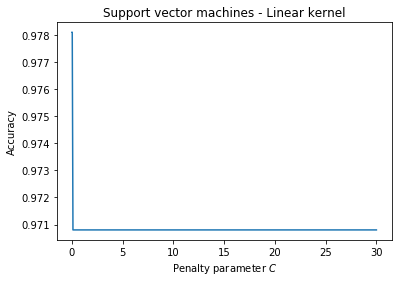

Best penalty parameter is 0.01
Consumed training time: 0.0
Confusion matrix:
[[88  1]
 [ 3 45]]


In [20]:
# Hyperparameter tuning
C = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
costs = np.empty(len(C))
for i, c in enumerate(C):
    svm = SVC(kernel='linear', C=c)
    svm.fit(X_train, y_train)
    costs[i] = svm.score(X_val, y_val)

# Show scores
plt.figure()
plt.plot(C, costs)
plt.xlabel('Penalty parameter $C$')
plt.ylabel('Accuracy')
plt.title('Support vector machines - Linear kernel')
plt.savefig('SVM_linear.png')
plt.show()

# Model selection
# Pick the model with maximum cross validation accuracy
best_c = C[costs.argmax()]
print('Best penalty parameter is {}'.format(best_c))

tic = time.process_time()
svm = SVC(kernel='linear', C=best_c)
svm.fit(X_train, y_train)
toc = time.process_time()
print('Consumed training time: {}'.format(toc - tic))

# Get a prediction
y_pred = svm.predict(X_test)

# Compute metrics
svm_linear_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(svm_linear_matrix)

#### Gaussian kernel

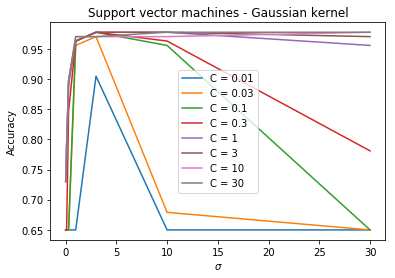

Best penalty parameter is 0.1
Best sigma for kernel coefficient is 3
Consumed training time: 0.0
Confusion matrix:
[[87  2]
 [ 3 45]]


In [21]:
# Hyperparameter tuning
C = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
sigma = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
costs = np.empty((len(C), len(sigma)))
for i, c in enumerate(C):
    for j, s in enumerate(sigma):
        svm = SVC(kernel='rbf', C=c, gamma=1 / (2 * s**2))
        svm.fit(X_train, y_train)
        costs[i, j] = svm.score(X_val, y_val)

# Show scores
plt.figure()
for i, c in enumerate(C):
    plt.plot(sigma, costs[i], label='C = ' + str(c))
plt.xlabel('$\sigma$')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Support vector machines - Gaussian kernel')
plt.savefig('SVM_RBF.png')
plt.show()

# Model selection
# Pick the model with maximum cross validation accuracy
best_c = C[costs.argmax() // len(sigma)]
best_sigma = sigma[costs.argmax() % len(sigma)]
print('Best penalty parameter is {}'.format(best_c))
print('Best sigma for kernel coefficient is {}'.format(best_sigma))

tic = time.process_time()
svm = SVC(kernel='rbf', C=best_c, gamma=1 / (2 * (best_sigma)**2))
svm.fit(X_train, y_train)
toc = time.process_time()
print('Consumed training time: {}'.format(toc - tic))

# Get a prediction
y_pred = svm.predict(X_test)

# Compute metrics
svm_rbf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(svm_rbf_matrix)

### K-means

In [22]:
tic = time.process_time()
kmeans = KMeans(n_clusters=2, random_state=1).fit(X_train)
toc = time.process_time()
print('Consumed training time: {}'.format(toc - tic))

# Get a prediction
y_pred = kmeans.predict(X_test)

# Compute metrics
kmeans_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(kmeans_matrix)

Consumed training time: 0.03125
Confusion matrix:
[[88  1]
 [ 6 42]]


## Phase 4 - Scores

In [23]:
accuracy = lambda M: (M[1, 1] + M[0, 0]) / (np.sum(M))

precision = lambda M: M[1, 1] / (M[1, 1] + M[0, 1])

recall = lambda M: M[1, 1] / (M[1, 1] + M[1, 0])

average = lambda P, R: (P + R) / 2

F1_score = lambda P, R: 2 * P * R / (P + R)

In [24]:
scores = np.empty((8, 5))
matrices = [
    linreg_matrix, lr_matrix, lr_matrix_sk, nn_matrix, nn_matrix_sk,
    svm_linear_matrix, svm_rbf_matrix, kmeans_matrix
]

for i, m in enumerate(matrices):
    scores[i, 0] = accuracy(m)
    scores[i, 1] = precision(m)
    scores[i, 2] = recall(m)
    scores[i, 3] = average(scores[i, 1], scores[i, 2])
    scores[i, 4] = F1_score(scores[i, 1], scores[i, 2])

scores = pd.DataFrame(scores)
scores.columns = [
    'Accuracy', 'Precision', 'Recall', 'Average', '$F_{1}$ score'
]
scores.index = [
    'Linear regression', 'Logistic regression', 'Logistic R. (scikit-learn)',
    'Neural network', 'NN (scikit-learn)', 'Linear SVM', 'RBF SVM', 'K-means'
]
display(scores)

,Accuracy,Precision,Recall,Average,$F_{1}$ score
Linear regression,0.941606,0.976190,0.854167,0.915179,0.911111
Logistic regression,0.956204,0.956522,0.916667,0.936594,0.936170
Logistic R. (scikit-learn),0.963504,0.977778,0.916667,0.947222,0.946237
Neural network,0.970803,0.958333,0.958333,0.958333,0.958333
NN (scikit-learn),0.956204,0.956522,0.916667,0.936594,0.936170
Linear SVM,0.970803,0.978261,0.937500,0.957880,0.957447
RBF SVM,0.963504,0.957447,0.937500,0.947473,0.947368
K-means,0.948905,0.976744,0.875000,0.925872,0.923077
